# Created 2024-08-03
# Last Updated 2024-08-08
# Maxwell A. Fine 

### Goals:
* Make plots of SNR, Fluence, $E_{\nu}$ for the crab over many hours of observations
* Compare to 2019, 2024 Crab paper, and 2024 nature Paper
* Addtionaly make some stastical plots of the Crab in the different Bands


### TODO:
* [x] Add line for known DM of Crab
* [] Add fancy telephone number for crab 
* [x] Add fitted Power Laws to Cummlative burst plot
* [ ] Error bars for cummlative burst plot
* [ ] Try Folding Crab bursts? If so make plot
* [ ] Calibrate data
* [ ] Make width vs peak SNR plot like 2019 paper
* [ ] Convert SNR to Fluence, and $E_{\nu}$
* [ ] Convert to Burst Rate
* [ ] Make Arrival time plot



# Programing

 Important commands to make a txt file of all the good `.h5` files (run in `/data/frb`):

```bash
find . -type d -name 'good' -exec find {} -type f -name 'CRAB*.h5' \; >> /data/frb/crab_goodh5_candidates.txt
```


This one copies that file to your cwd (magic jupyter):
```bash
!scp uranus:/data/frb/crab_goodh5_candidates.txt .
```



 This one copies all the file names of the `.fil` files for CRAB to a `.txt` file (run in `/data/frb`):
```bash
find . -type d -exec find {} -type f -name 'CRAB*.fil' \; >> /data/frb/crab_fil.txt
```

run `record_fil_durations.py /data/frb/crab_fil.txt /data/frb/crab_fil_durations.txt` to record the .fil durations to a file

then 
```bash 
!scp maxfine@uranus:/data/frb/crab_fil_durations.txt .
```


In [2]:
pwd

'/home/afinemax/afinemax/khazad-dum/research/astron_2024/crab_analysis'

In [3]:
!scp uranus:/data/frb/crab_goodh5_candidates.txt .

crab_goodh5_candidates.txt                    100% 2521KB   9.2MB/s   00:00    


In [4]:
!scp uranus:/data/frb/crab_fil_durations.txt .

crab_fil_durations.txt                        100% 1633KB   9.1MB/s   00:00    


### Imports & Global Variables

In [5]:
import numpy as np 
import matplotlib.pyplot as plt     
import pandas as pd 
import os.path
import corner 
import os
from datetime import datetime, timedelta
import re

freq_ranges = {
    "L1": (1200,1300),
    "L2": (1300,1400),
    "PH": (400,420),
    "PV": (400,420),
} # in Mhz

# Band colors
band_colors = {'L1': '#D81B60', 'L2': '#1E88E5','PH': '#FFC107', 'PV': '#004D40'} 


h5_files = "crab_goodh5_candidates.txt"
fil_files = 'crab_fil_durations.txt'

true_crab_dm = 56.77 #pc/cm^3

#### Read in `.h5` information

In [6]:

def read_h5_df(h5_files):
    """
    Reads a file containing filenames, processes them into a DataFrame, and calculates wait times between candidates.

    Parameters:
    h5_files (str): The path to the file containing the filenames.

    Returns:
    pd.DataFrame: A DataFrame with processed data, including calculated wait times between consecutive candidates.
    """

    # Initialize an empty list to store the data
    data = []

    # Read the file and process each line
    with open(h5_files, "r") as f:
        for line in f:
            # Get the full filename
            filename = os.path.basename(line.strip())
            
            # Split the filename into parts
            parts = filename.split("_")
            
            # Extract relevant parts of the filename
            band = parts[1]
            fil_time_str = "-".join(parts[3:6]) + "T" + ":".join(parts[6:9])
            fil_time = datetime.fromisoformat(fil_time_str)
            candidate_time = fil_time + timedelta(seconds=float(parts[10]))
            dm = float(parts[12])
            snr = float(parts[14][:-4])
            
            # Append the data along with the filename to the list
            data.append([filename, band, candidate_time, dm, snr])

    # Create a DataFrame with the data and include a column for the filename
    df = pd.DataFrame(data, columns=["filename", "band", "candidate_time", "dm", "snr"])

    # Function to generate the .fil filename
    def generate_fil_filename(h5_filename):
        # Split the filename by '_tcand_' and take the first part
        base_filename = h5_filename.split('_tcand_')[0]
        # Add the .fil extension
        fil_filename = base_filename + '.fil'
        return fil_filename

    # Apply the function to create a new column 'fil_file'
    df['fil_file'] = df['filename'].apply(generate_fil_filename)

    # Remove duplicate entries
    num_entries_before = df.shape[0]
    df = df.drop_duplicates()
    num_entries_after = df.shape[0]
    print(f"Number of h5 entries before removing duplicates: {num_entries_before}")
    print(f"Number of h5 entries after removing duplicates: {num_entries_after}")

    # Ensure 'candidate_time' is in datetime format
    df['candidate_time'] = pd.to_datetime(df['candidate_time'])

    # Sort the DataFrame by 'band', 'fil_file', and 'candidate_time'
    df = df.sort_values(by=['band', 'fil_file', 'candidate_time'])

    # Calculate the wait time between consecutive candidates within each 'band' and 'fil_file'
    df['wait_time'] = df.groupby(['band', 'fil_file'])['candidate_time'].diff()

    # Display the DataFrame with the new 'wait_time' column
    print(df[['band', 'fil_file', 'candidate_time', 'wait_time']])

    # Display the first 3 rows
    print('\ndf looks like\n')
    print(df.head(3))

    return df




def read_in_fil_df(fil_files):
    # Load DataFrame, skipping lines starting with '#'
    df_fil = pd.read_csv(fil_files, sep=' ', comment='#', engine='python', names=['file_path', 'obs_time'])
    
    # Remove rows where 'file_path' contains 'tmp'
    df_filtered = df_fil[~df_fil['file_path'].str.contains('tmp')].copy()  # Use .copy() to avoid SettingWithCopyWarning

    # Print the length of the DataFrame before removing duplicates
    print(f"Length of DataFrame before removing duplicates: {len(df_filtered)}")
    
    # Define a function to classify the band based on 'file_path'
    def determine_band(file_path):
        if 'L1' in file_path:
            return 'L1_Band'
        elif 'L2' in file_path:
            return 'L2_Band'
        elif 'PH' in file_path:
            return 'PH_Band'
        elif 'PV' in file_path:
            return 'PV_Band'
        else:
            return 'Unknown_Band'
    
    # Apply the function to create a new 'band' column
    df_filtered['band'] = df_filtered['file_path'].apply(determine_band)
    
    # Function to extract filenames from 'file_path'
    def extract_filename(file_path):
        match = re.search(r'CRAB_.*_(\d{4}_\d{2}_\d{2})_\d{2}_\d{2}_\d{2}.fil$', file_path)
        return match.group(0) if match else None
    
    # Extract filenames and remove duplicates
    df_filtered['filename'] = df_filtered['file_path'].apply(extract_filename)
    df_unique = df_filtered.drop_duplicates(subset='filename').copy()  # Ensure df_unique is a copy
    
    # Print the length of the DataFrame after removing duplicates
    print(f"Length of DataFrame after removing duplicates: {len(df_unique)}")
    
    # Group by 'band' and calculate total durations in seconds
    band_durations = df_unique.groupby('band')['obs_time'].sum()
    
    # Set the durations as variables
    durations = {
        'L1_Band': band_durations.get('L1_Band', 0),
        'L2_Band': band_durations.get('L2_Band', 0),
        'PH_Band': band_durations.get('PH_Band', 0),
        'PV_Band': band_durations.get('PV_Band', 0),
        'Unknown_Band': band_durations.get('Unknown_Band', 0)
    }

    # Print durations in seconds and hours
    # Convert durations to hours
    durations_hours = {band: duration / 3600 for band, duration in durations.items()}
    
    for band in durations:
        print(f"{band} Duration: {durations[band]} Seconds ({durations_hours[band]:.2f} Hours)")
    
    # Function to extract date from 'file_path' and convert to yyyy-mm-dd format
    def extract_date(file_path):
        match = re.search(r'(\d{4}_\d{2}_\d{2})', file_path)
        return match.group(1).replace('_', '-') if match else None
    
    # Apply the function to create a new 'date' column
    df_unique['date'] = df_unique['file_path'].apply(extract_date)
    
    # Get unique dates
    unique_dates = df_unique['date'].unique()
    
    # Print the observation log
    print('Observation Log')
    print("Unique dates:", unique_dates)
    
    # Return both the DataFrame and the durations dictionary
    return df_unique, durations





In [7]:
# read in info from log files
df_h5 = df = read_h5_df(h5_files)

# Filter the DataFrame to keep only rows where 'snr' > 15
df = df[df['snr'] > 15]

df_h5 = df

df_unique_fil, durations = read_in_fil_df(fil_files)

print()


Number of h5 entries before removing duplicates: 29257
Number of h5 entries after removing duplicates: 15521
      band                              fil_file             candidate_time  \
2522    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:26:08.312006   
3077    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:26:44.421005   
3088    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:11.470662   
2699    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:24.351386   
3230    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:53.106093   
...    ...                                   ...                        ...   
24709   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:53:44.600704   
25093   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:02.496832   
25558   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:17.008768   
24700   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:33.463360   
24808   PV  CRAB_PV_Ba

### DM vs SNR corner plots

In [8]:
def plot_corner_snr_dm_by_band(df, bands=['L1', 'L2', 'PH', 'PV'], band_colors=None, save_path='corner_plot_snr_dm{}.png'):
    """
    Creates corner plots for SNR and DM values from the DataFrame for each band and a total plot.
    Saves each band plot and the total plot to a file. Additionally, prints the expected SNR and DM 
    along with their upper and lower bounds.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'snr', 'dm', and 'band' columns.
    - bands (list): List of band names to create plots for.
    - band_colors (dict): Dictionary mapping band names to colors.
    - save_path (str): Path where the plot image will be saved. Default is 'corner_plot_{}.png'.
                        '{}' will be replaced by the band name or 'total' for the total plot.
    """
    # Ensure the DataFrame contains the required columns
    if not all(col in df.columns for col in ['snr', 'dm', 'band']):
        raise ValueError("DataFrame must contain 'snr', 'dm', and 'band' columns")
    
    results = {}
    
    for band in bands:
        # Filter the DataFrame for the current band
        band_data = df[df['band'] == band][['snr', 'dm']].copy()
        
        if band_data.empty:
            print(f"No data available for band {band}. Skipping...")
            continue
        
        # Creating the corner plot
        figure = corner.corner(band_data.values, labels=["SNR", "DM"], 
                               quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                               title_kwargs={"fontsize": 12},
                               color=band_colors.get(band, 'blue'))
        
        # Extract the quantiles
        snr_quantiles = np.percentile(band_data['snr'], [16, 50, 84])
        dm_quantiles = np.percentile(band_data['dm'], [16, 50, 84])
        
        # Save the results
        results[band] = {
            'SNR': {
                'Expected': snr_quantiles[1],
                'Lower Bound': snr_quantiles[0],
                'Upper Bound': snr_quantiles[2]
            },
            'DM': {
                'Expected': dm_quantiles[1],
                'Lower Bound': dm_quantiles[0],
                'Upper Bound': dm_quantiles[2]
            }
        }
        
        # Adjusting the space to prevent the title from overlapping with the plot
        plt.subplots_adjust(top=0.87)  # Adjust the top spacing
        
        # Adding the title
        plt.suptitle(f'Crab {band}\n', fontsize=16)
        
        # Saving the plot
        plot_path = save_path.format(band)
        figure.savefig(plot_path)
        
        # Display the plot
        plt.show()
    
    # Plotting the total SNR and DM
    total_data = df[['snr', 'dm']].copy()
    
    if not total_data.empty:
        # Creating the corner plot for the total data
        figure_total = corner.corner(total_data.values, labels=["SNR", "DM"], 
                                     quantiles=[0.16, 0.5, 0.84], show_titles=True, 
                                     title_kwargs={"fontsize": 12},
                                     color='black')
        
        # Extract the quantiles for the total data
        total_snr_quantiles = np.percentile(total_data['snr'], [16, 50, 84])
        total_dm_quantiles = np.percentile(total_data['dm'], [16, 50, 84])
        
        # Save the results for total data
        results['Total'] = {
            'SNR': {
                'Expected': total_snr_quantiles[1],
                'Lower Bound': total_snr_quantiles[0],
                'Upper Bound': total_snr_quantiles[2]
            },
            'DM': {
                'Expected': total_dm_quantiles[1],
                'Lower Bound': total_dm_quantiles[0],
                'Upper Bound': total_dm_quantiles[2]
            }
        }
        
        # Adjusting the space to prevent the title from overlapping with the plot
        plt.subplots_adjust(top=0.87)  # Adjust the top spacing
        
        # Adding the title
        plt.suptitle('Crab Total\n', fontsize=16)
        
        # Saving the plot
        plot_path_total = save_path.format('total')
        figure_total.savefig(plot_path_total)
        
        # Display the plot
        plt.show()
    
    # Print the results
    for band, data in results.items():
        print(f"\nBand: {band}")
        print(f"SNR: Expected = {data['SNR']['Expected']}, Lower Bound = {data['SNR']['Lower Bound']}, Upper Bound = {data['SNR']['Upper Bound']}")
        print(f"DM: Expected = {data['DM']['Expected']}, Lower Bound = {data['DM']['Lower Bound']}, Upper Bound = {data['DM']['Upper Bound']}")
    
    return results

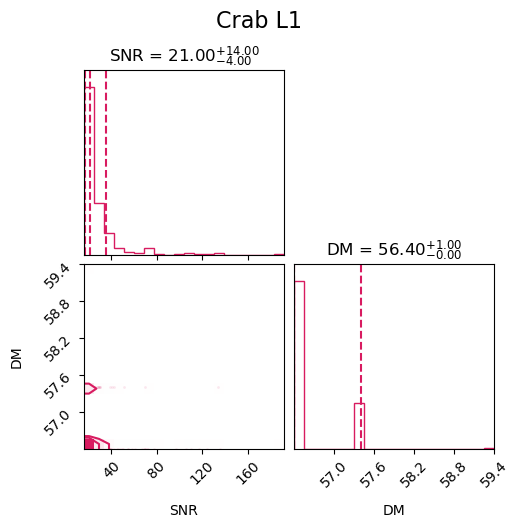

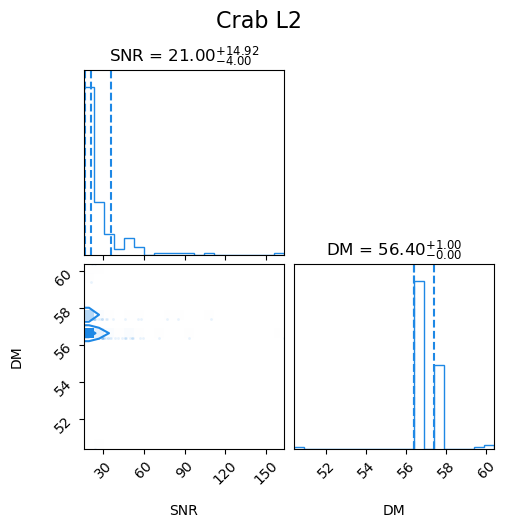

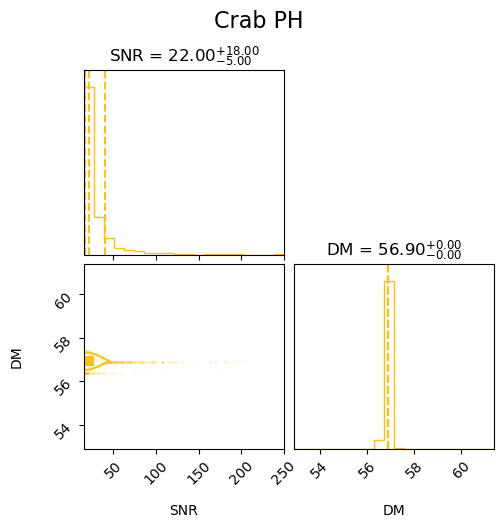

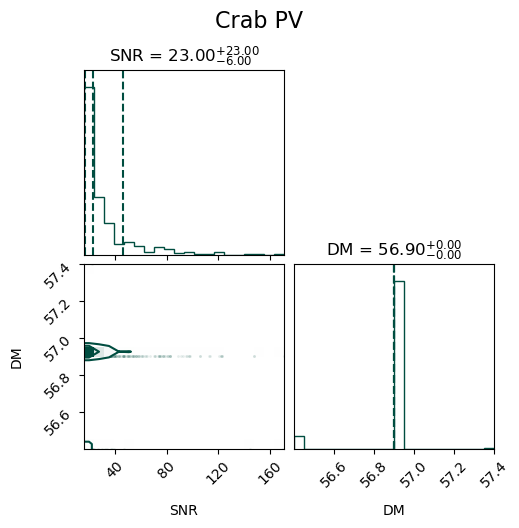

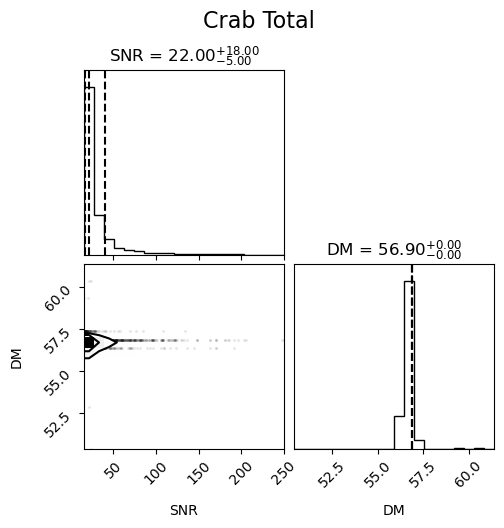


Band: L1
SNR: Expected = 21.0, Lower Bound = 17.0, Upper Bound = 35.0
DM: Expected = 56.4, Lower Bound = 56.4, Upper Bound = 57.4

Band: L2
SNR: Expected = 21.0, Lower Bound = 17.0, Upper Bound = 35.92
DM: Expected = 56.4, Lower Bound = 56.4, Upper Bound = 57.4

Band: PH
SNR: Expected = 22.0, Lower Bound = 17.0, Upper Bound = 40.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9

Band: PV
SNR: Expected = 23.0, Lower Bound = 17.0, Upper Bound = 46.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9

Band: Total
SNR: Expected = 22.0, Lower Bound = 17.0, Upper Bound = 40.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9


In [9]:
results = plot_corner_snr_dm_by_band(df, band_colors=band_colors)

### DM of observations 

In [10]:
def plot_dm_histogram(df, band_colors, save_path='crab_dm.png'):
    """
    Plots histograms of DM values from the DataFrame and saves the plot to a file.
    
    Parameters:
    - df (pd.DataFrame): DataFrame containing 'band', 'candidate_time', 'dm', 'snr' columns.
    - band_colors (dict): Dictionary mapping bands to colors. 
    - save_path (str): Path where the plot image will be saved. Default is 'crab_dm.png'.
    """
    # Set the size of the figure (width, height) in inches
    fig_size = (10, 6)  

    # Set up the figure
    fig, ax = plt.subplots(figsize=fig_size)

    # Set overall title for the entire figure
    plt.suptitle('Measured DM of Crab', size=15)

    # Get unique bands and initialize the color dictionary
    bands = df['band'].unique()

    # Plot histogram for the total dataset
    total_dm_values = df['dm']
    total_n = len(total_dm_values)
    total_num_bins = int(np.sqrt(total_n))  # Square root of number of data points
    ax.hist(total_dm_values, bins=total_num_bins, color='black', edgecolor='black', alpha=0.5, 
            density=True, label=f'Total, N = {total_n}')

    # Plot histogram for each band
    for i, band in enumerate(bands):
        band_data = df[df['band'] == band]
        dm_values = band_data['dm']
        
        # Calculate number of bins
        num_bins = int(np.sqrt(len(dm_values)))  # Square root of number of data points

        # Plot histogram with normalization
        ax.hist(dm_values, bins=num_bins, color=band_colors.get(band, 'gray'), edgecolor='black', alpha=0.5, 
                density=True, label=f'{band}, N = {len(dm_values)}')

    # Add a vertical dashed line for the true DM value of the Crab Pulsar
    true_dm = true_crab_dm # True DM value for the Crab Pulsar in pc/cm^3
    ax.axvline(x=true_dm, color='k', linestyle='--', linewidth= 3, label=f'True DM = {true_dm} pc/cm^3',)

    # Labeling and legend
    ax.set_xlabel('DM (pc/cm^3)', size=15)
    ax.set_ylabel('Probability', size=15)
    ax.legend(title='Bands', title_fontsize='13', fontsize='12')

    # Adjust layout
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust to fit suptitle and legend

    # Save the plot to a file
    plt.savefig(save_path)

    # Display the plot
    plt.show()


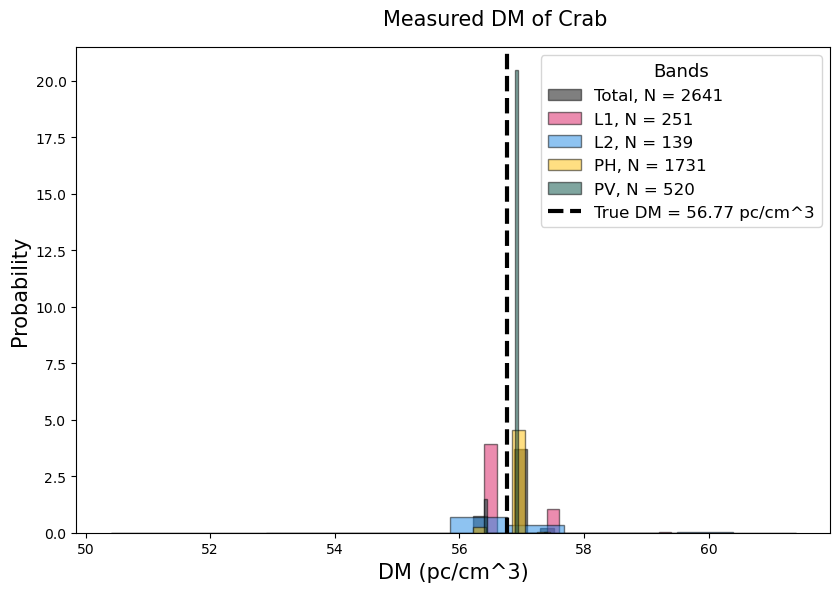

In [11]:
plot_dm_histogram(df, band_colors, )

### We want to remove all observations with measured DM more then 5 DM units away from the true DM. This was done in the 2019 paper, I think it is a reasonably physically motivated cutoff



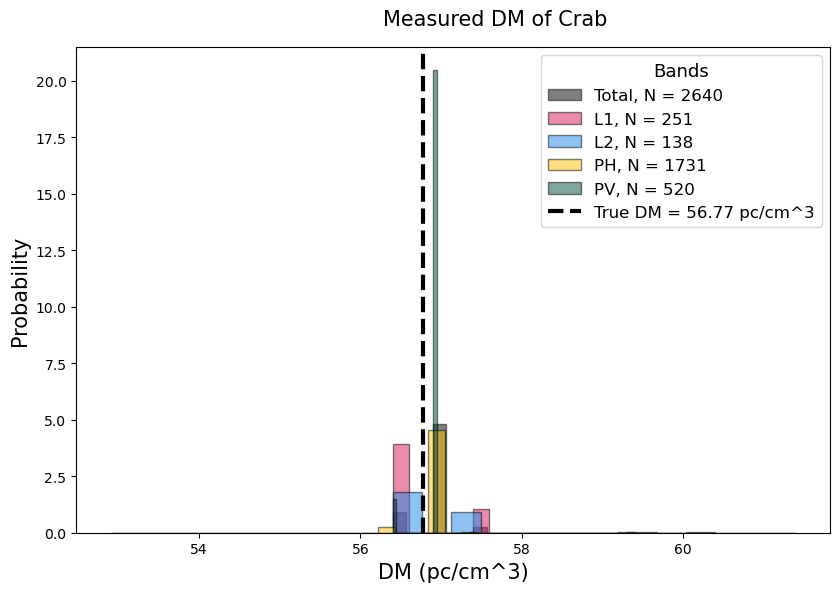

In [12]:
df= df[abs(df['dm'] - true_crab_dm) <= 5]
plot_dm_histogram(df, band_colors, )

### SNR plot

In [26]:
def plot_snr_histogram(df, band_colors, save_path='snr_freq.png'):
    """
    Plot histogram of SNR values for different bands and save the plot if required.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'band' and 'snr' columns.
    band_colors (dict): Dictionary mapping bands to colors. 
    save_path (str, optional): Path to save the plot image. If None, the plot is not saved. Defaults to None.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    bands = df['band'].unique()
    total_snr = np.concatenate([df[df['band'] == band]['snr'].values for band in bands])
    N_total = len(total_snr)
    
    # Log-spaced bins
    if N_total > 1:
        bin_edges_total = np.logspace(np.log10(total_snr.min()), np.log10(total_snr.max()), num=int(np.sqrt(0.5 * N_total)) + 1)
    else:
        bin_edges_total = np.array([total_snr.min(), total_snr.max()])

    total_counts, _ = np.histogram(total_snr, bins=bin_edges_total)
    total_bin_centers = (bin_edges_total[:-1] + bin_edges_total[1:]) / 2

    # Calculate bin widths in log scale
    total_bin_widths = bin_edges_total[1:] - bin_edges_total[:-1]

    # Calculate errors
    total_errors = total_counts / np.sqrt([np.sum((total_snr >= bin_edges_total[i]) & (total_snr < bin_edges_total[i+1])) for i in range(len(bin_edges_total) - 1)])
    
    # Plot total histogram in black
    ax.errorbar(total_bin_centers, total_counts, xerr=total_bin_widths / 2, yerr=total_errors, fmt='o', color='black', alpha=0.7, label=f'Total,N = {N_total}')

    # Plot each band's histogram
    for band in bands:
        band_data = df[df['band'] == band]
        N = len(band_data)  # Number of samples in the current band
        
        if N > 1:
            bin_edges_band = np.logspace(np.log10(band_data['snr'].min()), np.log10(band_data['snr'].max()), num=int(np.sqrt(N)) + 1)
        else:
            bin_edges_band = np.array([band_data['snr'].min(), band_data['snr'].max()])
        
        counts, _ = np.histogram(band_data['snr'], bins=bin_edges_band)
        bin_centers = (bin_edges_band[:-1] + bin_edges_band[1:]) / 2
        
        # Calculate bin widths in log scale
        bin_widths = bin_edges_band[1:] - bin_edges_band[:-1]
        
        # Calculate errors
        errors = counts / np.sqrt([np.sum((band_data['snr'] >= bin_edges_band[i]) & (band_data['snr'] < bin_edges_band[i+1])) for i in range(len(bin_edges_band) - 1)])
        
        # Plot scatter points with error bars
        ax.errorbar(bin_centers, counts, xerr=bin_widths / 2, yerr=errors, fmt='o', color=band_colors.get(band, 'gray') if band_colors else 'gray', alpha=0.6, label=f'Crab {band}, N = {N}')

    # Add labels and legend
    ax.set_title('SNR vs freq', size=15)
    ax.set_xlabel('SNR', size=15)
    ax.set_ylabel('Count', size=15)
    ax.set_yscale('log')  # Set y-axis to log scale
    ax.set_xscale('log')  # Set x-axis to log scale
    ax.legend(title='Band')

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path)

    plt.show()


/tmp/ipykernel_7993/3901440064.py:30: RuntimeWarning: invalid value encountered in divide
  total_errors = total_counts / np.sqrt([np.sum((total_snr >= bin_edges_total[i]) & (total_snr < bin_edges_total[i+1])) for i in range(len(bin_edges_total) - 1)])
/tmp/ipykernel_7993/3901440064.py:52: RuntimeWarning: invalid value encountered in divide
  errors = counts / np.sqrt([np.sum((band_data['snr'] >= bin_edges_band[i]) & (band_data['snr'] < bin_edges_band[i+1])) for i in range(len(bin_edges_band) - 1)])


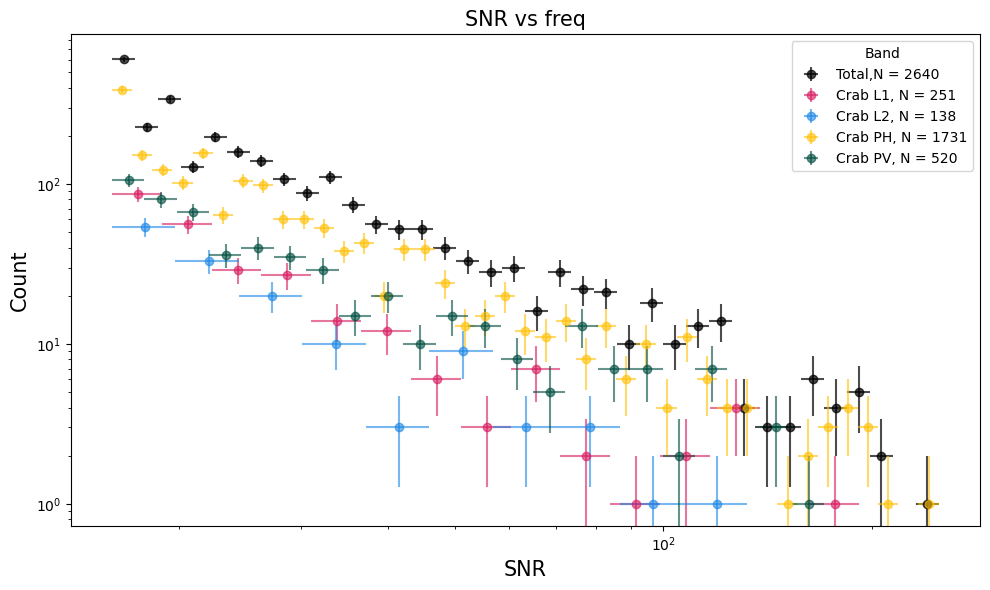

In [27]:
plot_snr_histogram(df, band_colors=band_colors, save_path='snr_freq.png')


### Cumulative SNR plot

In [25]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt


def bootstrap_errors(df, num_bootstrap=1000):
    """
    Calculate bootstrap errors for the cumulative count in the SNR distribution.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'band' and 'snr' columns.
    num_bootstrap (int, optional): Number of bootstrap samples to generate. Defaults to 1000.

    Returns:
    dict: Dictionary containing the standard errors for each band and the total cumulative distribution.
    """
    bootstrap_counts = {}

    # Total data
    total_bootstrap = []
    for _ in range(num_bootstrap):
        sample = df.sample(frac=1, replace=True)  # Bootstrap resample
        sample_sorted = sample.sort_values(by='snr')
        cumulative_count = len(sample_sorted) - sample_sorted.reset_index().index
        total_bootstrap.append(cumulative_count.values)
    bootstrap_counts['Total'] = np.std(total_bootstrap, axis=0)  # Calculate standard error

    # Per-band data
    for band in df['band'].unique():
        band_bootstrap = []
        for _ in range(num_bootstrap):
            sample = df[df['band'] == band].sample(frac=1, replace=True)  # Bootstrap resample
            sample_sorted = sample.sort_values(by='snr')
            cumulative_count = len(sample_sorted) - sample_sorted.reset_index().index
            band_bootstrap.append(cumulative_count.values)
        bootstrap_counts[band] = np.std(band_bootstrap, axis=0)  # Calculate standard error

    return bootstrap_counts




def power_law(x, scaling_factor, exponent):
    return scaling_factor * x ** exponent

def fit_power_law(df):
    fit_results = {}
    residuals = {}
    normalized_residuals = {}
    observed = {}

    total_data = df.sort_values(by='snr')
    total_data['cumulative_count'] = len(total_data) - total_data.reset_index().index
    x_total = total_data['snr'].values
    y_total = total_data['cumulative_count'].values

    valid = (x_total > 0) & (y_total > 0)
    x_total, y_total = x_total[valid], y_total[valid]

    params_total, covariance_total = curve_fit(power_law, x_total, y_total, p0=[1, 1])
    scaling_factor, exponent = params_total
    scaling_factor_error, exponent_error = np.sqrt(np.diag(covariance_total))

    y_fit_total = power_law(x_total, *params_total)
    residuals['Total'] = y_total - y_fit_total
    observed['Total'] = (x_total, y_total)

    # Normalize residuals for total data
    residuals_std_total = np.std(residuals['Total'])
    normalized_residuals['Total'] = residuals['Total'] / residuals_std_total

    chi2_total = np.sum((residuals['Total']**2) / y_fit_total)
    reduced_chi2_total = chi2_total / (len(x_total) - len(params_total))

    fit_results['Total'] = (scaling_factor, exponent, scaling_factor_error, exponent_error, reduced_chi2_total)

    for band in df['band'].unique():
        band_data = df[df['band'] == band].sort_values(by='snr')
        band_data['cumulative_count'] = len(band_data) - band_data.reset_index().index
        x_band = band_data['snr'].values
        y_band = band_data['cumulative_count'].values

        valid = (x_band > 0) & (y_band > 0)
        x_band, y_band = x_band[valid], y_band[valid]

        params_band, covariance_band = curve_fit(power_law, x_band, y_band, p0=[1, 1])
        scaling_factor, exponent = params_band
        scaling_factor_error, exponent_error = np.sqrt(np.diag(covariance_band))

        y_fit_band = power_law(x_band, *params_band)
        residuals[band] = y_band - y_fit_band
        observed[band] = (x_band, y_band)

        # Normalize residuals for each band
        residuals_std_band = np.std(residuals[band])
        normalized_residuals[band] = residuals[band] / residuals_std_band

        chi2_band = np.sum((residuals[band]**2) / y_fit_band)
        reduced_chi2_band = chi2_band / (len(x_band) - len(params_band))

        fit_results[band] = (scaling_factor, exponent, scaling_factor_error, exponent_error, reduced_chi2_band)

    return fit_results, normalized_residuals, observed






def plot_residuals(df, residuals, observed, power_law_results=None, band_colors=None, save_path='residuals_plot.png'):
    if band_colors is None:
        band_colors = {}

    bands = ['Total'] + list(df['band'].unique())

    fig, axs = plt.subplots(len(bands), 1, figsize=(10, 12), sharex=True, sharey=True)

    if len(bands) == 1:
        axs = [axs]  # Make sure axs is iterable if there's only one plot

    for i, band in enumerate(bands):
        ax = axs[i]
        x_data, y_data = observed[band]
        residual = residuals[band]
        
        color = band_colors.get(band, 'black') if band != 'Total' else 'black'

        ax.scatter(x_data, residual, label=f'{band} Normalized Residuals', color=color, alpha=0.7)
        ax.axhline(0, color='black', linestyle='--')

        ax.set_ylabel('Normalized Residuals', size=12)
        ax.set_xscale('log')
        ax.set_title(f'{band}')

        if i == len(bands) - 1:
            ax.set_xlabel('SNR', size=12)

    plt.suptitle('Normalized Residuals (/ std of residual) of Power Law Fits', size=16)
    plt.tight_layout(rect=[0, 0, 0.9, 0.96])

    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    if power_law_results:
        for band, (scaling_factor, exponent, scaling_factor_error, exponent_error, reduced_chi2) in power_law_results.items():
            print(f"{band}: Reduced Chi-Square = {reduced_chi2:.2f}")

# Example usage:
# df = pd.DataFrame({'band': [...], 'snr': [...]})
# band_colors = {'Band1': 'red', 'Band2': 'blue', ...}
# power_law_results, normalized_residuals, observed = fit_power_law(df)
# plot_residuals(df, normalized_residuals, observed, power_law_results)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def power_law(x, scaling_factor, exponent):
    return scaling_factor * x ** (exponent)

def plot_cumulative_snr(df, band_colors, power_law_results=None, save_path='cumulative_snr.png'):
    """
    Plot cumulative histogram of SNR values for different bands and total across all bands, and save the plot if required.
    Optionally plot the fitted power laws with scaling factors.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'band' and 'snr' columns.
    band_colors (dict): Dictionary mapping bands to colors.
    power_law_results (dict, optional): Dictionary with power law scaling factors, exponents, and errors. Defaults to None.
    save_path (str, optional): Path to save the plot image. If None, the plot is not saved. Defaults to 'cumulative_snr.png'.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot cumulative distribution across all bands
    total_data = df.sort_values(by='snr')
    total_data['cumulative_count'] = len(total_data) - total_data.reset_index().index
    
    # Plot the total cumulative distribution on log-log scale
    ax.scatter(total_data['snr'], total_data['cumulative_count'], 
               label=f'Total (N={len(total_data)})', 
               color='black', alpha=0.9)
    
    # Plot cumulative distribution for each band
    for band in df['band'].unique():
        # Filter and sort data by SNR within each band
        band_data = df[df['band'] == band].sort_values(by='snr')
        
        # Calculate the inverted rank (cumulative number of bursts)
        band_data['cumulative_count'] = len(band_data) - band_data.reset_index().index
        
        # Plot the cumulative distribution on log-log scale
        ax.scatter(band_data['snr'], band_data['cumulative_count'], 
                   label=f'{band} (N={len(band_data)})', 
                   color=band_colors.get(band, 'gray'), alpha=0.7)
    
    # Optionally plot power law fits
    if power_law_results:
        x_vals = np.logspace(np.log10(df['snr'].min()), np.log10(df['snr'].max()), 100)
        
        # Plot power law for total data
        if 'Total' in power_law_results:
            scaling_factor, exponent, scaling_factor_error, exponent_error, reduced_chi2= power_law_results['Total']
            y_vals = power_law(x_vals, scaling_factor, exponent)
            ax.plot(x_vals, y_vals, 'k--', 
                    label=f'Total: $\gamma$={exponent:.2f} ± {exponent_error:.3f}', alpha=0.8)
            
            # Print fitted parameters for total
            print(f"Total: Scaling Factor = {scaling_factor:.2e}, Exponent = {exponent:.2f}, "
                  f"Scaling Factor Error = {scaling_factor_error:.2e}, Exponent Error = {exponent_error:.3f}, Reduced_chi2 = {reduced_chi2}")
        
        
        # Plot power law for each band
        for band in df['band'].unique():
            if band in power_law_results:
                scaling_factor, exponent, scaling_factor_error, exponent_error, reduced_chi2 = power_law_results[band]

                y_vals = power_law(x_vals, scaling_factor, exponent)
                ax.plot(x_vals, y_vals, color=band_colors.get(band, 'gray'), linestyle='--', 
                        label=f'{band}: $\gamma$={exponent:.2f} ± {exponent_error:.3f}', alpha=0.8)
                
            # Print fitted parameters for each band
                print(f"{band}: Scaling Factor = {scaling_factor:.2e}, Exponent = {exponent:.2f}, "
                      f"Scaling Factor Error = {scaling_factor_error:.2e}, Exponent Error = {exponent_error:.3f}, Reduced_chi2 = {reduced_chi2}")
    
    
    # Set plot labels and title
    ax.set_title('Cumulative SNR Burst Distribution', size=15)
    ax.set_xlabel('SNR', size=15)
    ax.set_ylabel('Cumulative Count', size=15)
    ax.set_yscale('log')  # Logarithmic y-axis
    ax.set_xscale('log')  # Logarithmic x-axis

    # Move the legend outside of the plot
    ax.legend(title='Band', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


Total: Scaling Factor = 5.90e+05, Exponent = -1.98, Scaling Factor Error = 7.21e+03, Exponent Error = 0.004, Reduced_chi2 = 1.7850707905909213
L1: Scaling Factor = 8.88e+04, Exponent = -2.15, Scaling Factor Error = 5.13e+03, Exponent Error = 0.020, Reduced_chi2 = 0.35654020560865485
L2: Scaling Factor = 4.75e+04, Exponent = -2.13, Scaling Factor Error = 3.16e+03, Exponent Error = 0.023, Reduced_chi2 = 0.15276962582599668
PH: Scaling Factor = 4.25e+05, Exponent = -2.01, Scaling Factor Error = 6.40e+03, Exponent Error = 0.005, Reduced_chi2 = 1.1034160044645132
PV: Scaling Factor = 6.29e+04, Exponent = -1.75, Scaling Factor Error = 1.52e+03, Exponent Error = 0.008, Reduced_chi2 = 0.4337465353076654


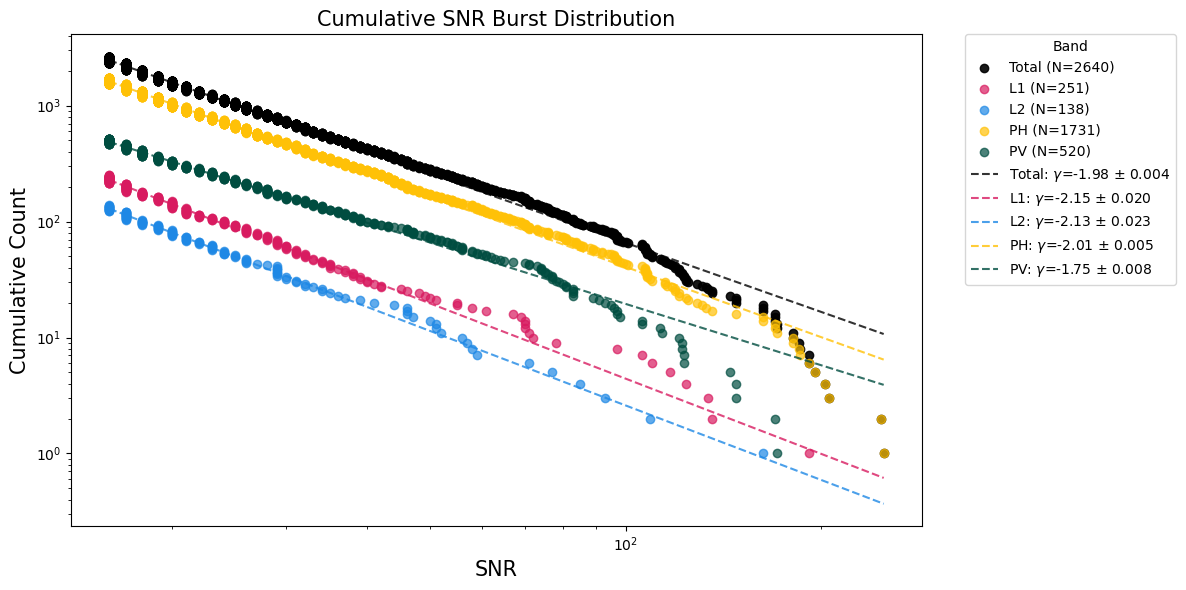

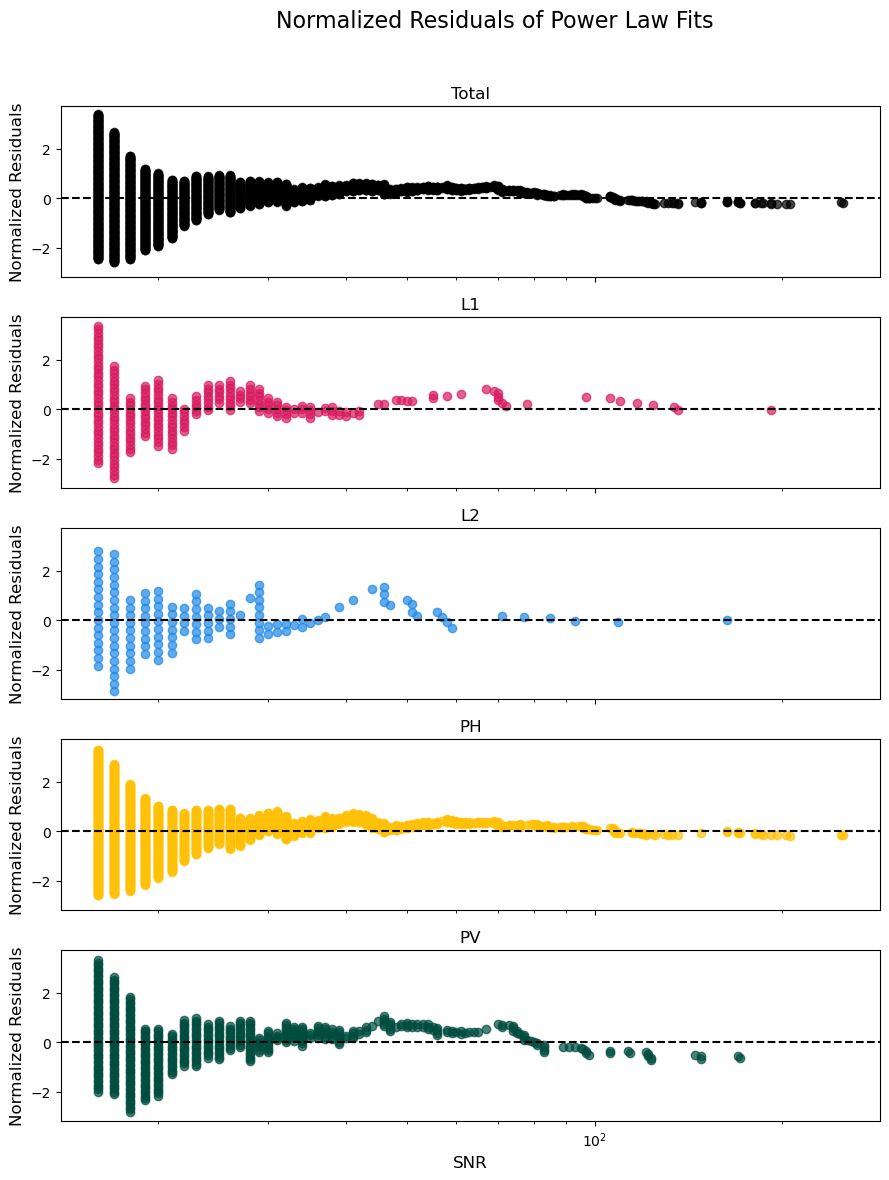

Total: Reduced Chi-Square = 1.79
L1: Reduced Chi-Square = 0.36
L2: Reduced Chi-Square = 0.15
PH: Reduced Chi-Square = 1.10
PV: Reduced Chi-Square = 0.43


In [17]:
power_law_results, residuals, observed = fit_power_law(df)
plot_cumulative_snr(df, band_colors, power_law_results)
plot_residuals(df, residuals, observed, power_law_results, band_colors=band_colors)


### Wait time plot

In [18]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cumulative_wait_time(df, band_colors, save_path='cumulative_wait_time.png'):
    """
    Plot cumulative histogram of wait times for different bands and the total across all bands, and save the plot if required.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'band', 'wait_time' columns.
    band_colors (dict): Dictionary mapping bands to colors.
    save_path (str, optional): Path to save the plot image. If None, the plot is not saved. Defaults to 'cumulative_wait_time.png'.
    """
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot cumulative distribution across all bands
    total_data = df.dropna(subset=['wait_time']).sort_values(by='wait_time')
    total_data['cumulative_count'] = len(total_data) - total_data.reset_index().index
    
    # Plot the total cumulative distribution on log-log scale
    ax.scatter(total_data['wait_time'].dt.total_seconds(), total_data['cumulative_count'], 
               label=f'Total (N={len(total_data)})', 
               color='black', alpha=0.9)
    
    # Plot cumulative distribution for each band
    for band in df['band'].unique():
        # Filter and sort data by wait time within each band
        band_data = df[df['band'] == band].dropna(subset=['wait_time']).sort_values(by='wait_time')
        
        # Calculate the inverted rank (cumulative number of candidates)
        band_data['cumulative_count'] = len(band_data) - band_data.reset_index().index
        
        # Plot the cumulative distribution on log-log scale
        ax.scatter(band_data['wait_time'].dt.total_seconds(), band_data['cumulative_count'], 
                   label=f'{band} (N={len(band_data)})', 
                   color=band_colors.get(band, 'gray'), alpha=0.7)
    
    # Set plot labels and title
    ax.set_title('Cumulative Wait Time Distribution', size=15)
    ax.set_xlabel('Wait Time (seconds)', size=15)
    ax.set_ylabel('Cumulative Count', size=15)
    #ax.set_yscale('log')  # Logarithmic y-axis
    ax.set_xscale('log')  # Logarithmic x-axis

    # Move the legend outside of the plot
    ax.legend(title='Band', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()


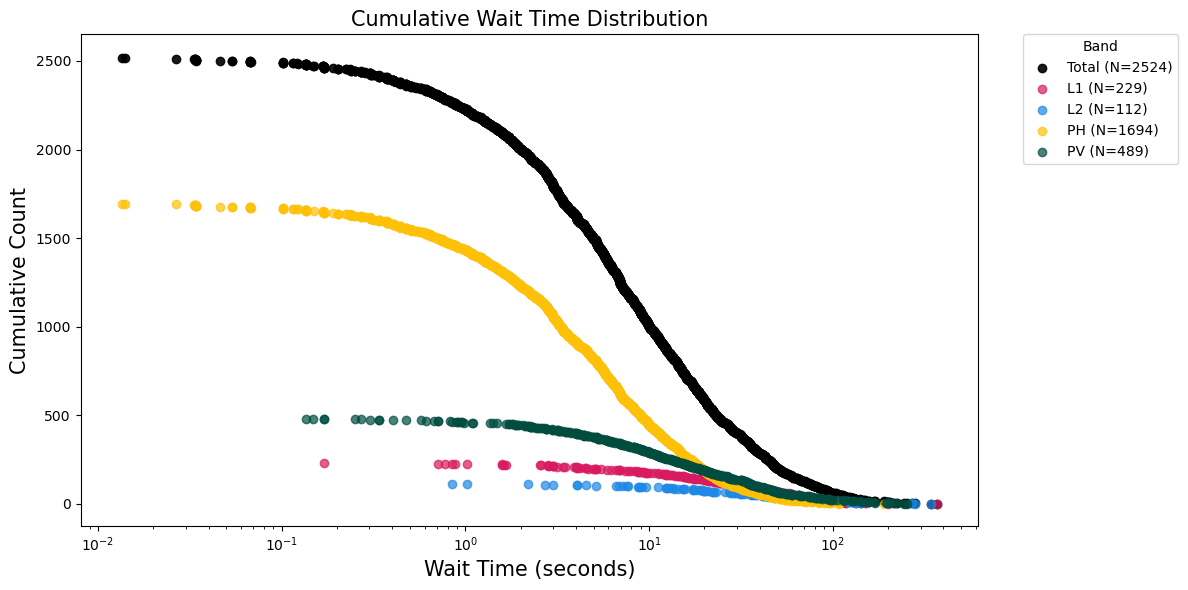

In [19]:
plot_cumulative_wait_time(df, band_colors)

### Burst Rate vs MJD



/tmp/ipykernel_7993/785433985.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_data['error'] = band_data['burst_rate'] / (band_data['burst_rate'] ** 0.5)
/tmp/ipykernel_7993/785433985.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_data['error'] = band_data['burst_rate'] / (band_data['burst_rate'] ** 0.5)
/tmp/ipykernel_7993/785433985.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



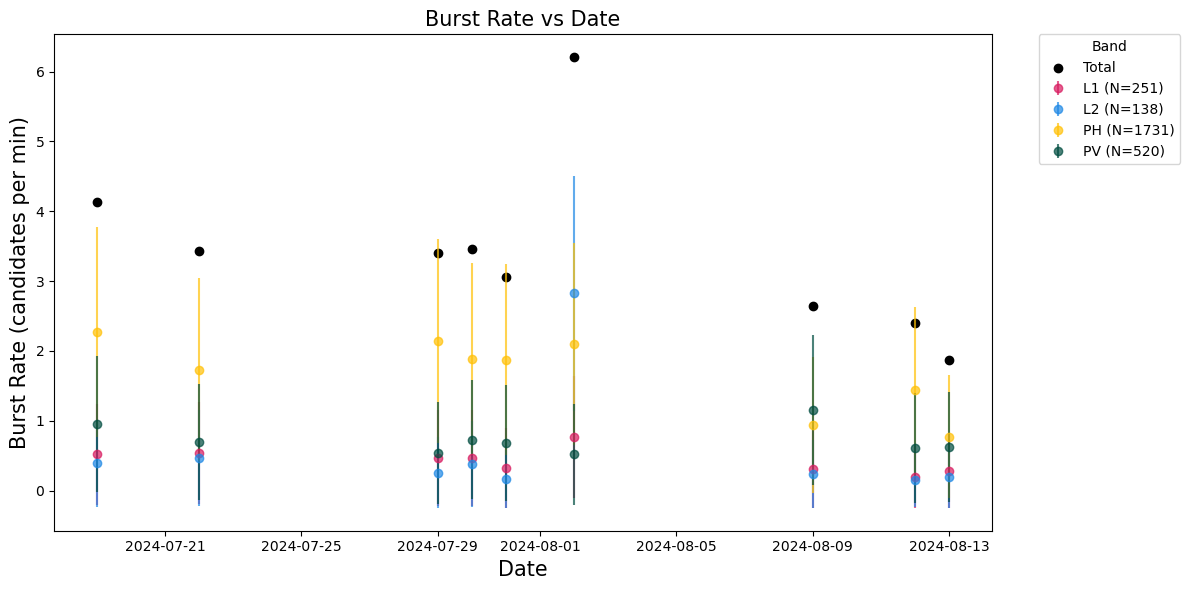

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_and_plot_burst_rate(df, df_unique_fil, band_colors, save_path='burst_rate_vs_date.png'):
    """
    Calculate the burst rate for each .fil file, group by date and band, and plot the burst rate.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing candidate data with 'candidate_time', 'fil_file', and 'band' columns.
    df_unique_fil (pd.DataFrame): DataFrame containing unique .fil file data with 'filename' and 'obs_time' columns.
    band_colors (dict): Dictionary mapping bands to colors.
    save_path (str, optional): Path to save the plot image. If None, the plot is not saved. Defaults to 'burst_rate_vs_date.png'.
    
    Returns:
    pd.DataFrame: DataFrame containing burst rate grouped by date and band.
    """
    # Convert 'candidate_time' to datetime if it's not already
    df['candidate_time'] = pd.to_datetime(df['candidate_time'])

    # Extract date from candidate_time for df
    df['date'] = df['candidate_time'].dt.date

    # Count the number of candidates per .fil file
    candidates_per_fil = df.groupby('fil_file').size().reset_index(name='num_candidates')

    # Ensure 'obs_time' exists in df_unique_fil
    if 'obs_time' not in df_unique_fil.columns:
        raise KeyError("'obs_time' column is not found in df_unique_fil. Please check the column names.")

    # Merge the candidate counts with the duration from df_unique_fil
    merged_df = pd.merge(candidates_per_fil, df_unique_fil[['filename', 'obs_time']], 
                         left_on='fil_file', right_on='filename')

    # Calculate duration in minutes from seconds
    merged_df['duration_min'] = merged_df['obs_time'] / 60  # minutes

    # Calculate burst rate for each .fil file
    merged_df['burst_rate'] = merged_df['num_candidates'] / merged_df['duration_min']

    # Merge back with df to get the date and band information
    merged_with_date = pd.merge(df[['fil_file', 'date', 'band']], merged_df[['fil_file', 'burst_rate']], 
                                on='fil_file')

    # Group by date and band, and calculate the average burst rate
    burst_rate_by_band_df = merged_with_date.groupby(['date', 'band']).agg({
        'burst_rate': 'mean',  # Average burst rate per day and band
        'fil_file': 'count'    # Count of .fil files per band
    }).reset_index().rename(columns={'fil_file': 'num_candidates'})

    # Create figure and axis for plotting
    fig, ax = plt.subplots(figsize=(12, 6))

    # Calculate the total burst rate per day
    total_burst_rate = burst_rate_by_band_df.groupby('date')['burst_rate'].sum().reset_index().rename(columns={'burst_rate': 'total_burst_rate'})

    # Merge total burst rate with original dataframe for plotting
    df_for_plotting = burst_rate_by_band_df.merge(total_burst_rate, on='date', how='left')

    # Plot burst rate for each band
    for band in df_for_plotting['band'].unique():
        # Filter data for the current band
        band_data = df_for_plotting[df_for_plotting['band'] == band]
        
        # Calculate Poisson error bars
        band_data['error'] = band_data['burst_rate'] / (band_data['burst_rate'] ** 0.5)
        
        # Scatter plot for burst rate
        ax.errorbar(band_data['date'], band_data['burst_rate'], 
                    yerr=band_data['error'], fmt='o', 
                    label=f'{band} (N={band_data["num_candidates"].sum()})', 
                    color=band_colors.get(band, 'gray'), alpha=0.7)
    
    # Plot total burst rate
    ax.scatter(total_burst_rate['date'], total_burst_rate['total_burst_rate'], 
               color='black', label='Total')

    # Set plot labels and title
    ax.set_title('Burst Rate vs Date', size=15)
    ax.set_xlabel('Date', size=15)
    ax.set_ylabel('Burst Rate (candidates per min)', size=15)

    # Move the legend outside of the plot
    ax.legend(title='Band', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.tight_layout()

    # Save the plot if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

    plt.show()

    return merged_with_date

# Example usage
burst_rate_by_band_df = calculate_and_plot_burst_rate(df_h5, df_unique_fil, band_colors)


### Outputs

In [23]:
# read in info from log files
df = read_h5_df(h5_files)

# Filter the DataFrame to keep only rows where 'snr' > 15
df = df[df['snr'] > 15]

# Filter df to cut out candidates more then 5 DM units away from true
df = df[abs(df['dm'] - true_crab_dm) <= 5]

df_h5 = df

df_unique_fil, durations = read_in_fil_df(fil_files)

print()


Number of h5 entries before removing duplicates: 29257
Number of h5 entries after removing duplicates: 15521
      band                              fil_file             candidate_time  \
2522    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:26:08.312006   
3077    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:26:44.421005   
3088    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:11.470662   
2699    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:24.351386   
3230    L1  CRAB_L1_Band_2024_07_19_16_25_42.fil 2024-07-19 16:27:53.106093   
...    ...                                   ...                        ...   
24709   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:53:44.600704   
25093   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:02.496832   
25558   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:17.008768   
24700   PV  CRAB_PV_Band_2024_08_13_16_46_43.fil 2024-08-13 16:54:33.463360   
24808   PV  CRAB_PV_Ba

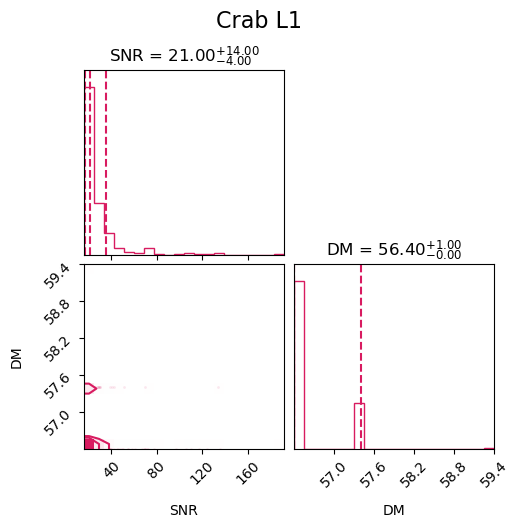

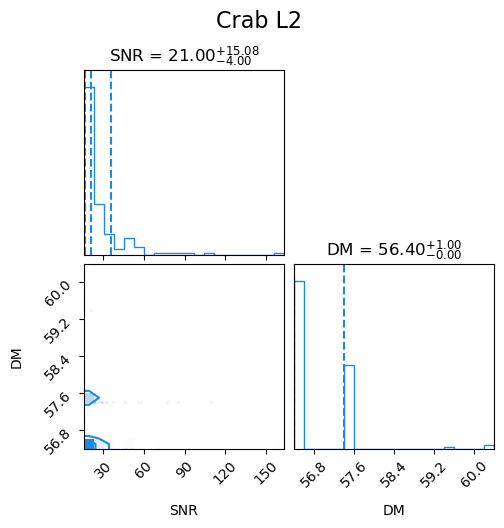

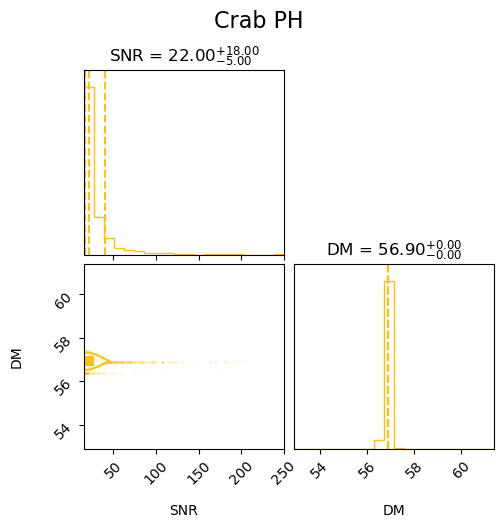

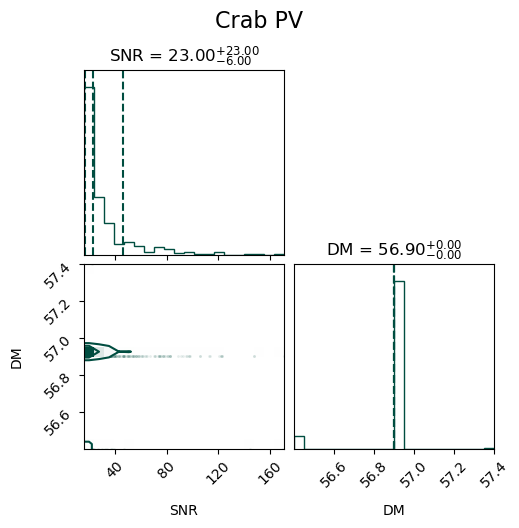

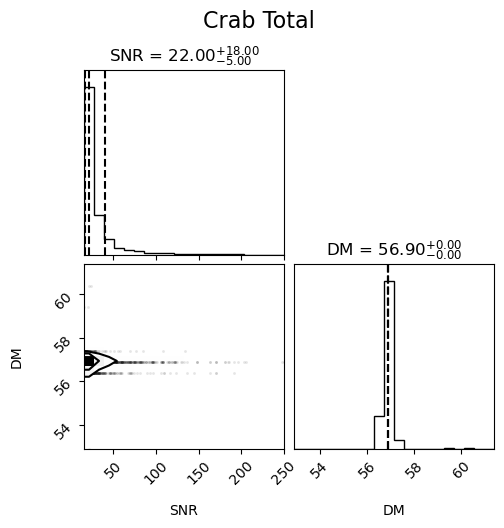


Band: L1
SNR: Expected = 21.0, Lower Bound = 17.0, Upper Bound = 35.0
DM: Expected = 56.4, Lower Bound = 56.4, Upper Bound = 57.4

Band: L2
SNR: Expected = 21.0, Lower Bound = 17.0, Upper Bound = 36.08
DM: Expected = 56.4, Lower Bound = 56.4, Upper Bound = 57.4

Band: PH
SNR: Expected = 22.0, Lower Bound = 17.0, Upper Bound = 40.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9

Band: PV
SNR: Expected = 23.0, Lower Bound = 17.0, Upper Bound = 46.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9

Band: Total
SNR: Expected = 22.0, Lower Bound = 17.0, Upper Bound = 40.0
DM: Expected = 56.9, Lower Bound = 56.9, Upper Bound = 56.9


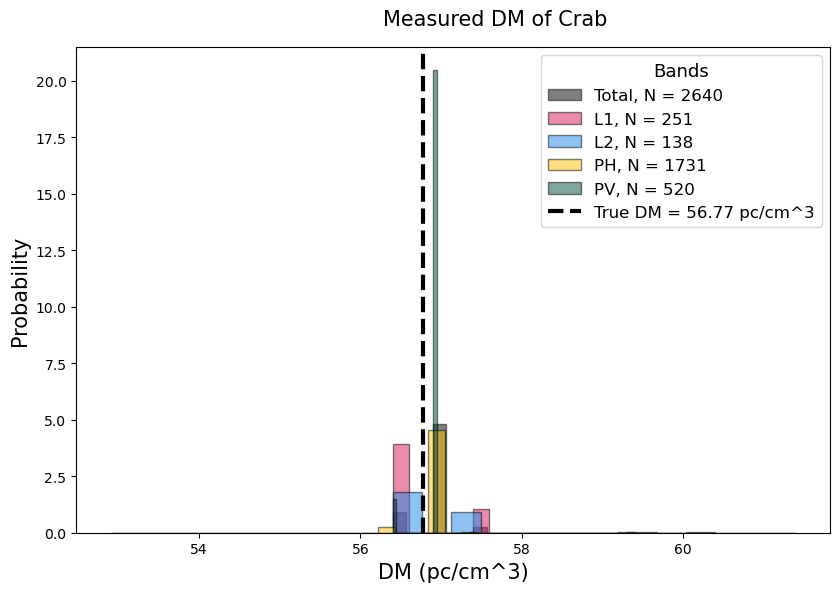

/tmp/ipykernel_7993/3901440064.py:30: RuntimeWarning: invalid value encountered in divide
  total_errors = total_counts / np.sqrt([np.sum((total_snr >= bin_edges_total[i]) & (total_snr < bin_edges_total[i+1])) for i in range(len(bin_edges_total) - 1)])
/tmp/ipykernel_7993/3901440064.py:52: RuntimeWarning: invalid value encountered in divide
  errors = counts / np.sqrt([np.sum((band_data['snr'] >= bin_edges_band[i]) & (band_data['snr'] < bin_edges_band[i+1])) for i in range(len(bin_edges_band) - 1)])


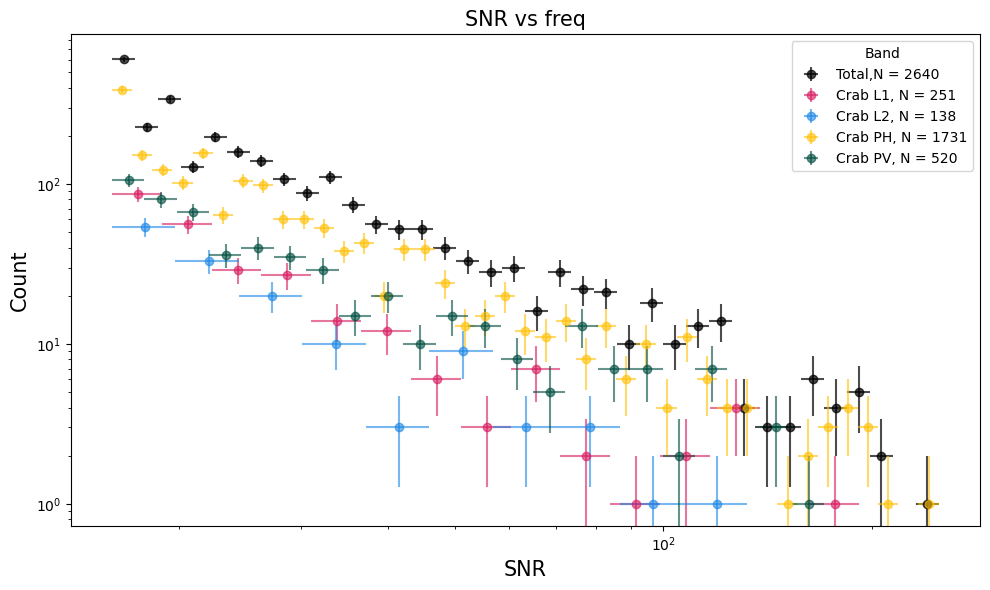

Total: Scaling Factor = 5.90e+05, Exponent = -1.98, Scaling Factor Error = 7.21e+03, Exponent Error = 0.004, Reduced_chi2 = 1.7850707905909213
L1: Scaling Factor = 8.88e+04, Exponent = -2.15, Scaling Factor Error = 5.13e+03, Exponent Error = 0.020, Reduced_chi2 = 0.35654020560865485
L2: Scaling Factor = 4.75e+04, Exponent = -2.13, Scaling Factor Error = 3.16e+03, Exponent Error = 0.023, Reduced_chi2 = 0.15276962582599668
PH: Scaling Factor = 4.25e+05, Exponent = -2.01, Scaling Factor Error = 6.40e+03, Exponent Error = 0.005, Reduced_chi2 = 1.1034160044645132
PV: Scaling Factor = 6.29e+04, Exponent = -1.75, Scaling Factor Error = 1.52e+03, Exponent Error = 0.008, Reduced_chi2 = 0.4337465353076654


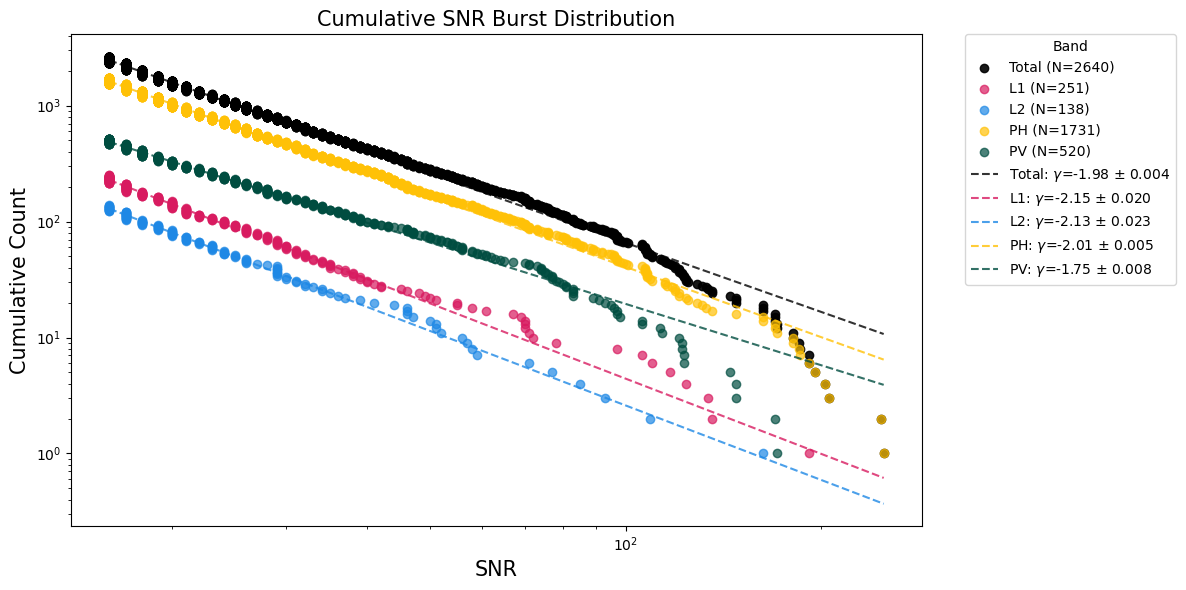

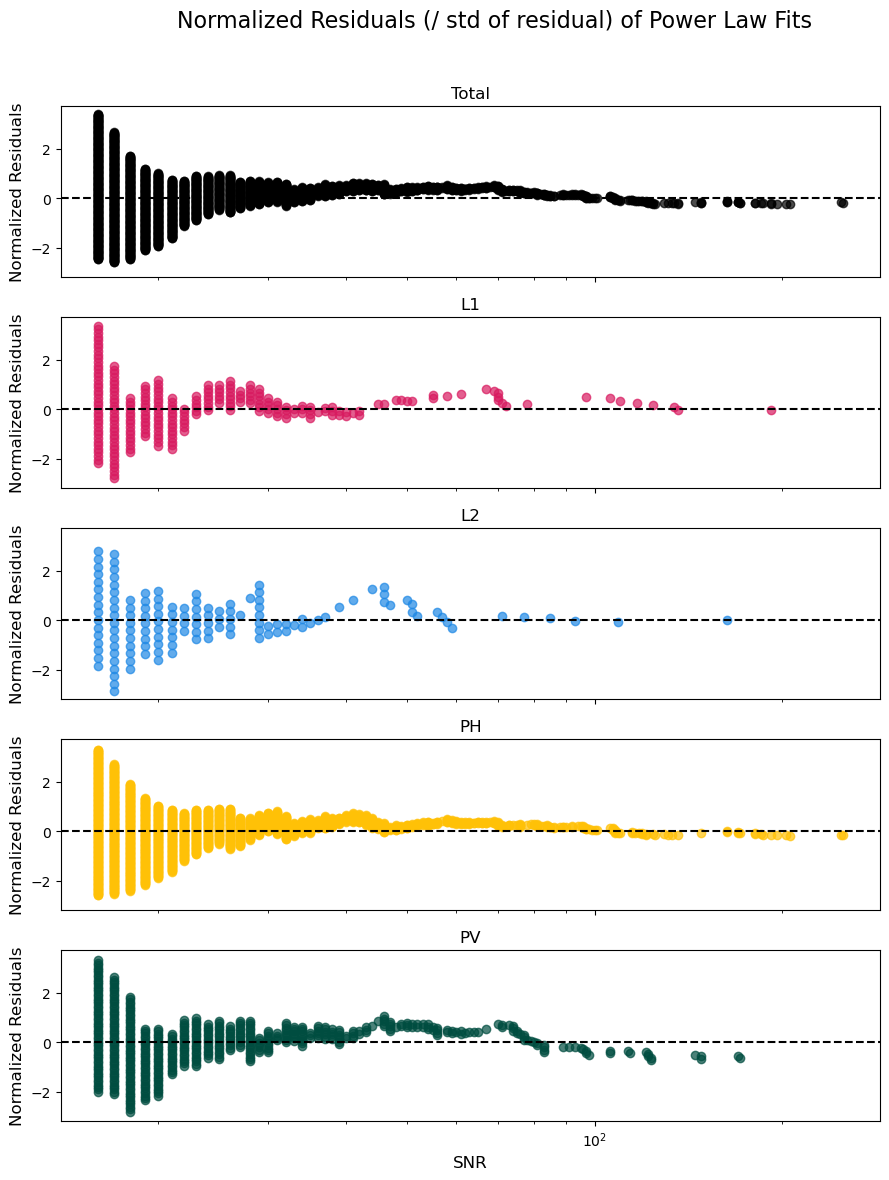

Total: Reduced Chi-Square = 1.79
L1: Reduced Chi-Square = 0.36
L2: Reduced Chi-Square = 0.15
PH: Reduced Chi-Square = 1.10
PV: Reduced Chi-Square = 0.43


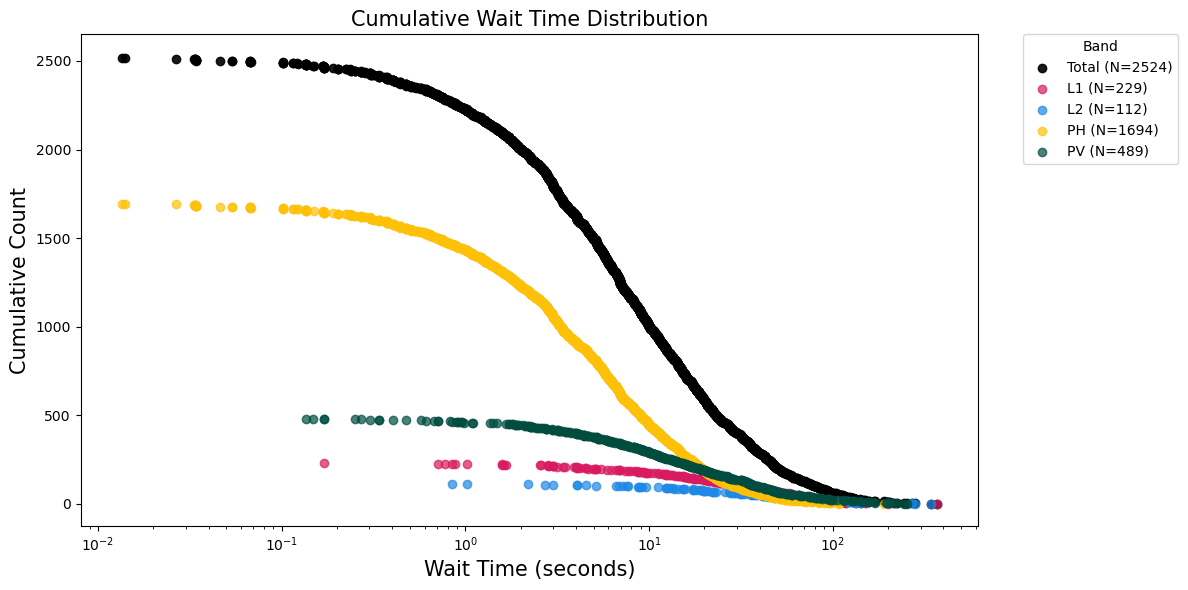

/tmp/ipykernel_7993/2885288352.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_data['error'] = band_data['burst_rate'] / (band_data['burst_rate'] ** 0.5)
/tmp/ipykernel_7993/2885288352.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  band_data['error'] = band_data['burst_rate'] / (band_data['burst_rate'] ** 0.5)
/tmp/ipykernel_7993/2885288352.py:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

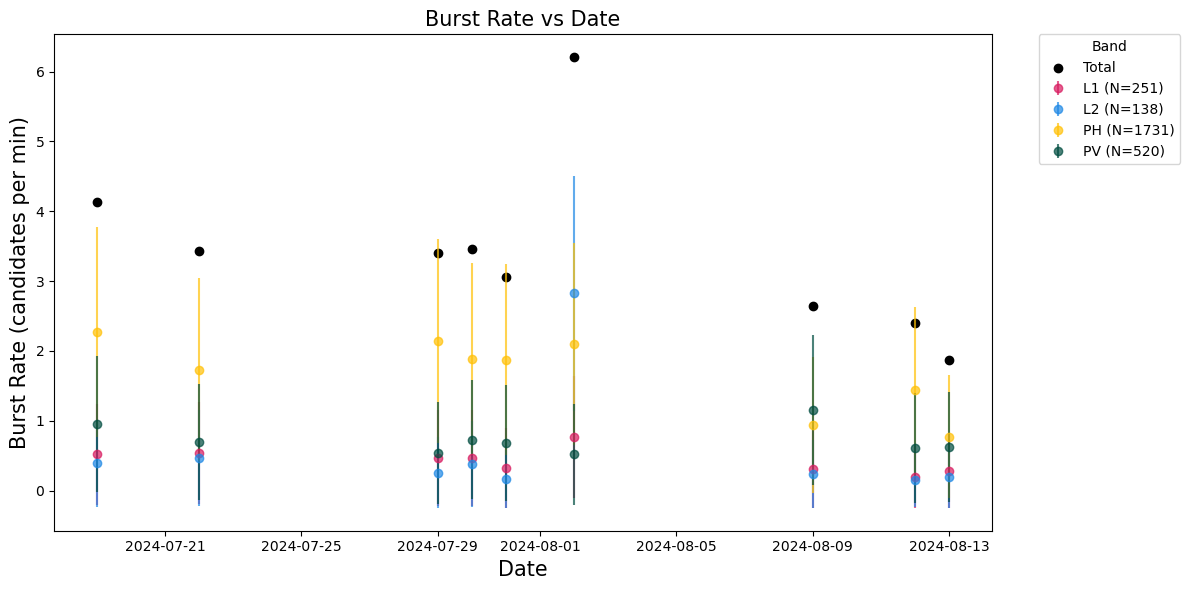

In [32]:
results = plot_corner_snr_dm_by_band(df, band_colors=band_colors)

plot_dm_histogram(df, band_colors, )

plot_snr_histogram(df, band_colors=band_colors, save_path='snr_freq.png')


power_law_results, residuals, observed = fit_power_law(df)

plot_cumulative_snr(df, band_colors, power_law_results)

plot_residuals(df, residuals, observed, power_law_results, band_colors=band_colors)

plot_cumulative_wait_time(df, band_colors)

burst_rate_by_band_df = calculate_and_plot_burst_rate(df_h5, df_unique_fil, band_colors)



In [37]:
burst_rate_by_band_df 

,fil_file,date,band,burst_rate
0,CRAB_L1_Band_2024_07_19_16_36_45.fil,2024-07-19,L1,1.515537
1,CRAB_L1_Band_2024_07_19_16_44_51.fil,2024-07-19,L1,0.200000
2,CRAB_L1_Band_2024_07_19_16_44_51.fil,2024-07-19,L1,0.200000
3,CRAB_L1_Band_2024_07_19_16_56_53.fil,2024-07-19,L1,0.605521
4,CRAB_L1_Band_2024_07_19_17_12_24.fil,2024-07-19,L1,0.468123
...,...,...,...,...
2635,CRAB_PV_Band_2024_08_13_16_36_42.fil,2024-08-13,PV,0.200000
2636,CRAB_PV_Band_2024_08_13_16_46_43.fil,2024-08-13,PV,0.400000
2637,CRAB_PV_Band_2024_08_13_16_46_43.fil,2024-08-13,PV,0.400000
2638,CRAB_PV_Band_2024_08_13_16_46_43.fil,2024-08-13,PV,0.400000


In [38]:
df

,filename,band,candidate_time,dm,snr,fil_file,wait_time,date
3421,CRAB_L1_Band_2024_07_19_16_36_45_tcand_5.70896...,L1,2024-07-19 16:36:50.708960,56.4,20.0,CRAB_L1_Band_2024_07_19_16_36_45.fil,NaT,2024-07-19
3549,CRAB_L1_Band_2024_07_19_16_44_51_tcand_40.3533...,L1,2024-07-19 16:45:31.353370,57.4,16.0,CRAB_L1_Band_2024_07_19_16_44_51.fil,0 days 00:00:01.589383,2024-07-19
2510,CRAB_L1_Band_2024_07_19_16_44_51_tcand_243.360...,L1,2024-07-19 16:48:54.360614,57.4,17.0,CRAB_L1_Band_2024_07_19_16_44_51.fil,0 days 00:00:58.456179,2024-07-19
3407,CRAB_L1_Band_2024_07_19_16_56_53_tcand_73.2605...,L1,2024-07-19 16:58:06.260589,56.4,18.0,CRAB_L1_Band_2024_07_19_16_56_53.fil,0 days 00:00:02.807955,2024-07-19
2893,CRAB_L1_Band_2024_07_19_17_12_24_tcand_20.5593...,L1,2024-07-19 17:12:44.559398,56.4,16.0,CRAB_L1_Band_2024_07_19_17_12_24.fil,0 days 00:00:00.845977,2024-07-19
...,...,...,...,...,...,...,...,...
24653,CRAB_PV_Band_2024_08_13_16_36_42_tcand_520.344...,PV,2024-08-13 16:45:22.344768,56.9,31.0,CRAB_PV_Band_2024_08_13_16_36_42.fil,0 days 00:00:10.553856,2024-08-13
24842,CRAB_PV_Band_2024_08_13_16_46_43_tcand_68.4622...,PV,2024-08-13 16:47:51.462208,56.9,53.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:33.896448,2024-08-13
25166,CRAB_PV_Band_2024_08_13_16_46_43_tcand_70.6949...,PV,2024-08-13 16:47:53.694976,56.9,55.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:02.232768,2024-08-13
24935,CRAB_PV_Band_2024_08_13_16_46_43_tcand_213.723...,PV,2024-08-13 16:50:16.723072,56.9,20.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:17.726400,2024-08-13


In [39]:
df_unique_fil

,file_path,obs_time,band,filename,date
0,./2024-07-22/PV_Band/CRAB_PV_Band_2024_07_22_1...,600.000000,PV_Band,CRAB_PV_Band_2024_07_22_15_45_13.fil,2024-07-22
1,./2024-07-22/PV_Band/CRAB_PV_Band_2024_07_22_1...,600.000000,PV_Band,CRAB_PV_Band_2024_07_22_14_01_25.fil,2024-07-22
2,./2024-07-22/PV_Band/CRAB_PV_Band_2024_07_22_1...,600.000000,PV_Band,CRAB_PV_Band_2024_07_22_16_25_17.fil,2024-07-22
3,./2024-07-22/PV_Band/CRAB_PV_Band_2024_07_22_1...,600.000000,PV_Band,CRAB_PV_Band_2024_07_22_16_15_16.fil,2024-07-22
4,./2024-07-22/PV_Band/CRAB_PV_Band_2024_07_22_1...,600.000000,PV_Band,CRAB_PV_Band_2024_07_22_14_20_04.fil,2024-07-22
...,...,...,...,...,...
14288,./2024-08-13/L1_Band/CRAB_L1_Band_2024_08_13_1...,599.999891,L1_Band,CRAB_L1_Band_2024_08_13_12_47_36.fil,2024-08-13
14289,./2024-08-13/L1_Band/CRAB_L1_Band_2024_08_13_1...,599.999891,L1_Band,CRAB_L1_Band_2024_08_13_16_36_46.fil,2024-08-13
14290,./2024-08-13/L1_Band/CRAB_L1_Band_2024_08_13_1...,225.100672,L1_Band,CRAB_L1_Band_2024_08_13_12_24_14.fil,2024-08-13
14291,./2024-08-13/L1_Band/CRAB_L1_Band_2024_08_13_1...,599.999891,L1_Band,CRAB_L1_Band_2024_08_13_15_46_41.fil,2024-08-13


In [43]:
import pandas as pd

# Assuming df and df_unique_fil are your DataFrames

# Merge the DataFrames on the matching columns
df_merged = pd.merge(df, df_unique_fil[['filename', 'obs_time', 'file_path']], left_on='fil_file', right_on='filename', how='left')

# Drop the duplicate 'filename' column from the merged DataFrame if not needed
df_merged = df_merged.drop(columns=['filename_y'])

# Optionally, you can rename the 'filename_x' column back to 'filename'
df_merged = df_merged.rename(columns={'filename_x': 'filename'})




In [44]:
df_merged

,filename,band,candidate_time,dm,snr,fil_file,wait_time,date,obs_time,file_path
0,CRAB_L1_Band_2024_07_19_16_36_45_tcand_5.70896...,L1,2024-07-19 16:36:50.708960,56.4,20.0,CRAB_L1_Band_2024_07_19_16_36_45.fil,NaT,2024-07-19,39.589926,./2024-07-19/L1_Band/CRAB_L1_Band_2024_07_19_1...
1,CRAB_L1_Band_2024_07_19_16_44_51_tcand_40.3533...,L1,2024-07-19 16:45:31.353370,57.4,16.0,CRAB_L1_Band_2024_07_19_16_44_51.fil,0 days 00:00:01.589383,2024-07-19,599.999891,./2024-07-19/L1_Band/CRAB_L1_Band_2024_07_19_1...
2,CRAB_L1_Band_2024_07_19_16_44_51_tcand_243.360...,L1,2024-07-19 16:48:54.360614,57.4,17.0,CRAB_L1_Band_2024_07_19_16_44_51.fil,0 days 00:00:58.456179,2024-07-19,599.999891,./2024-07-19/L1_Band/CRAB_L1_Band_2024_07_19_1...
3,CRAB_L1_Band_2024_07_19_16_56_53_tcand_73.2605...,L1,2024-07-19 16:58:06.260589,56.4,18.0,CRAB_L1_Band_2024_07_19_16_56_53.fil,0 days 00:00:02.807955,2024-07-19,99.088301,./2024-07-19/L1_Band/CRAB_L1_Band_2024_07_19_1...
4,CRAB_L1_Band_2024_07_19_17_12_24_tcand_20.5593...,L1,2024-07-19 17:12:44.559398,56.4,16.0,CRAB_L1_Band_2024_07_19_17_12_24.fil,0 days 00:00:00.845977,2024-07-19,128.171360,./2024-07-19/L1_Band/CRAB_L1_Band_2024_07_19_1...
...,...,...,...,...,...,...,...,...,...,...
2635,CRAB_PV_Band_2024_08_13_16_36_42_tcand_520.344...,PV,2024-08-13 16:45:22.344768,56.9,31.0,CRAB_PV_Band_2024_08_13_16_36_42.fil,0 days 00:00:10.553856,2024-08-13,600.000000,./2024-08-13/PV_Band/CRAB_PV_Band_2024_08_13_1...
2636,CRAB_PV_Band_2024_08_13_16_46_43_tcand_68.4622...,PV,2024-08-13 16:47:51.462208,56.9,53.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:33.896448,2024-08-13,600.000000,./2024-08-13/PV_Band/CRAB_PV_Band_2024_08_13_1...
2637,CRAB_PV_Band_2024_08_13_16_46_43_tcand_70.6949...,PV,2024-08-13 16:47:53.694976,56.9,55.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:02.232768,2024-08-13,600.000000,./2024-08-13/PV_Band/CRAB_PV_Band_2024_08_13_1...
2638,CRAB_PV_Band_2024_08_13_16_46_43_tcand_213.723...,PV,2024-08-13 16:50:16.723072,56.9,20.0,CRAB_PV_Band_2024_08_13_16_46_43.fil,0 days 00:00:17.726400,2024-08-13,600.000000,./2024-08-13/PV_Band/CRAB_PV_Band_2024_08_13_1...


In [45]:
df_merged.to_csv('crab_pulses_catalog.csv', index=False)